# Frequency Domain
SPI2 Basics on Image processing

Ecole Centrale Nantes

Diana Mateus

Participant: (**Abiy DEMA**)

## 0. Preparation 

### 0.1 Import the required modules


In [1]:
from scipy import ndimage
from scipy import fftpack
import matplotlib.pyplot as plt
import numpy as np
import os
import skimage.io as io
from skimage.transform import resize

##  2. PROJECT JPEG

**Introduction**

The jpeg compression follows several steps

**i)** Convert images from RGB to YIQ color space

**ii)** Reduce the size (to half) of the I and Q channels

**iii)** An image is first subdivided in 8x8 subblocks (assuming the original image has sides whose length is a multiple of 8, if it is not the case just resize it).

**iv)** A frequency transformation is computed for each block (computed with a discrete cosine transform DCT II )
```
fftpack.dct(fftpack.dct(im.T, norm='ortho').T, norm='ortho')
```
**v)** The DCT results are then divided by the elements of the the quantization matrices given in ```quantization_table```. The resulting values are then rounded and stored as integers. **Hint:** use the functions  ```round()```, ```astype(np.int32)```

**vi)** The result of quantization (which should have many zeros) is then compressed Run Lenght Coding and Huffman coding to reduce the size. The compressed values are saved together with the quantization table.

**vii)** The reconstruction of the image implies inverting the encoding, the quantization and the dct.



**Instructions**

- This project is individual! This means both the code and report should be original and different for each of you. The 0 grade will apply for any attempt to break this rule.

- You are expected to return both the jupyter notebook along with a report explaining the method and the results of the jpeg compression on SEVERAL images.


- You are **ONLY** allowed to use:
    - any ``numpy`` and ``matplotlib`` functions 
    - ``io.imread`` to read the images
    - the provided functions to compute the ``dct``  
    - the provided functions to compute the quantization matrix ```quantization_table```. 
    - other functions from ``skimage`` are not needed!!! I will tolerate them only in the case you completely explain in the report (with descriptions and equations)  what this functions do.


- If you use code from an external source, this source should be cited. Failinig to do so, also leads to a grade of 0.


- The first cell of the notebook must start with the definition of the ```filename``` variable, which especifies the path of the image that will be compressed. To test your code on other images, I will only change this line. The code should run adapting to any input image.


- Implement all the jpeg compression steps (i-v) . Do **NOT** implement step vi) Run Lenght Code and Huffman coding


- Create **one function for each step**. Demonstrate the results of each step by calling each function: Show with images or graphs how the input image/list/data looks like before and after applying that function.


- Implement the inverse steps, to go from the quantized dct values to the reconstructed images. Again use one function per step, and illustrate its results


- Create a global jpegCompress function englobing steps i-v and a jpegDecompress function englobin steps in vii)


- Call the jpegCompress and jpeg Decompress function on several images: e.g. before and after applying a gaussian filter, before and after downsizing the image, on images with high or low frequency content. Compare the images (e.g. by computing their differences). Write some comments for every experiment you try. 


- Compare how the frequency representation of the original and the compressed images, look at the spectrum magnitude and phase. You may also want to compare the histogram of the frequency components.

**BONUS** Replace the given DCT function by your own basis implementation. Explain any difference.


In [2]:
filename = "images/Frequency/face1.jpg"  # Definition of the path of an image

In [3]:
im = io.imread(filename)       # Reads the filename
im = (im/255).astype(float) # To be sure is always between 0 and 1 after this cell

print("\n*********************************************************")

print("Original shape :", im.shape)
print("Min = ",im.min(), ",", "\nMax = ",im.max())

(h,w) = (128,128)                                          # Resize small first to debug
im = resize(im,(h,w),mode='constant') # This function will put the intensitites between 0 and 1 -> multiply by 255 when needed

print("\n*********************************************************")

print("Resized shape= ",im.shape)                                                            # Resized image-shape
print("Resized min  = ",im.min(),"\nResized max  = ",im.max())   # Resized image-min & max values

print("\n*********************************************************")


*********************************************************
Original shape : (267, 247, 3)
Min =  0.0 , 
Max =  1.0

*********************************************************
Resized shape=  (128, 128, 3)
Resized min  =  0.0018751869211599533 
Resized max  =  1.0

*********************************************************


In [4]:
#https://datacarpentry.org/image-processing/05-creating-histograms/

def plot_histogram(getimage, row, column, order):                                                           #  Takes the image and  some information for the histogram graph
    min_pixel, max_pixel = np.amin(getimage), np.amax(getimage)                              #  Gets the minimum and maximum pixel of the image 
    hist, bins = np.histogram(getimage, bins=256, range=(min_pixel, max_pixel)) #  For the graph to have a range
    bins = (bins[:-1] + bins[1:])/2                                                                                            #  Equally-spaced intervals  (X-axis)                                                                            
    ax=plt.subplot(row, column, order)                                                                                  #  Takes the number of rows , columns and  place of the image(order : n-th place)
    plt.plot(bins, hist)                                                                                                                    #  X-axis and Y-axis respectively
    #plt.xlabel("Color values", fontsize=10)
    plt.ylabel("Pixel values", fontsize=10) 
    plt.rcParams["figure.figsize"] = [20,20] 
    plt.rc('xtick', labelsize=10)
    plt.rc('ytick', labelsize=10)  
    ax.set_xlim([min_pixel, max_pixel])                                                                                  #  The graph will be shown including the  two extremes

In [5]:
#i) Convert images from RGB to YIQ color space

In [6]:
#https://stackoverflow.com/questions/46990838/numpy-transforming-rgb-image-to-yiq-color-space
#https://en.wikipedia.org/wiki/YIQ

def RGB_YIQ (getimage):
    
    getimage = (getimage*255).astype(float) # Changing it into 0-255 range since the quantization table is based on intensities in between that range.
    YIQ = np.array(
            [[0.299, 0.587, 0.114],
             [0.5959, -0.274, -0.3213],  
             [0.2115, -0.5227, 0.3112]]) 
    
    YIQ_img = (np.dot(getimage, YIQ.T)) 
    Y, I, Q = YIQ_img[:,:,0], YIQ_img[:,:,1], YIQ_img[:,:,2] # Y- index 0, I-index 1, Q-index 2
    
    return YIQ_img                                                  

def YIQ_RGB (Y, I, Q):
    
    (h,w)=Y.shape
    RGB_img = np.zeros((h,w,3))
    
    # Back to the original image whose intensities was between 0 and 1
    R = (Y + 0.956*I + 0.619*Q )/255
    G = (Y - 0.272*I - 0.647*Q )/255
    B = (Y - 1.106*I + 1.1703*Q)/255
  
    RGB_img[:,:,0], RGB_img[:,:,1], RGB_img[:,:,2] =R,G,B # R- index 0, G-index 1, B-index 2
     
    return RGB_img

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


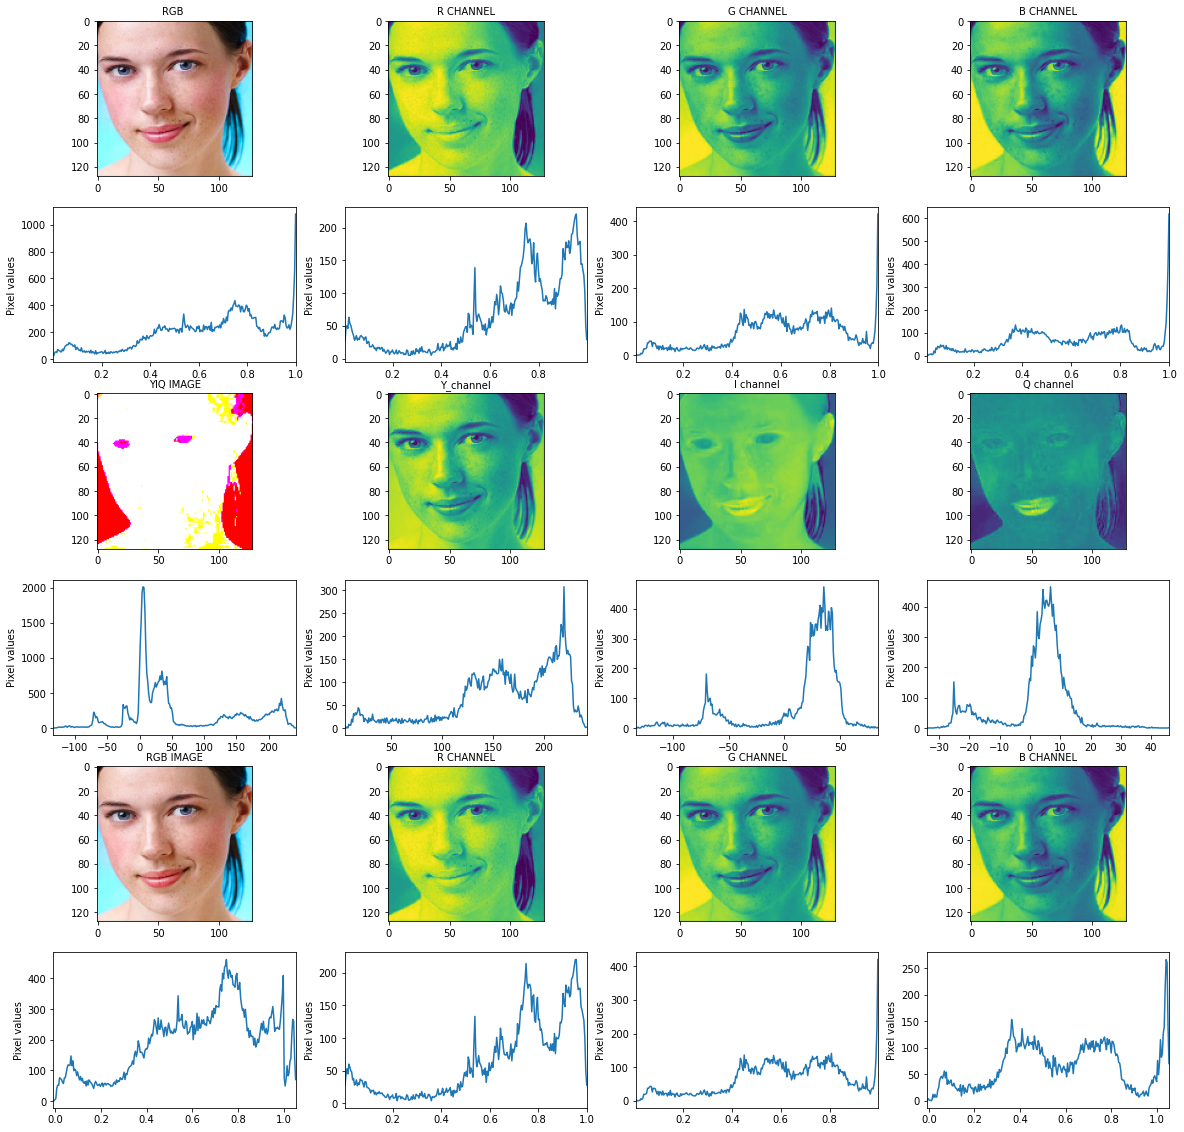

In [7]:
plt.rcParams["figure.figsize"] = [20,20] 
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)    
  
original=im  
plt.subplot(6,4,1), plt.imshow(original), plt.title("RGB ",fontsize = 10), plot_histogram(original, 6,4,5)                                        # Original RGB image
plt.subplot(6,4,2), plt.imshow(original[:,:,0]), plt.title("R CHANNEL",fontsize = 10), plot_histogram(original[:,:,0], 6,4,6)      # R-channel
plt.subplot(6,4,3), plt.imshow(original[:,:,1]), plt.title("G CHANNEL",fontsize = 10), plot_histogram(original[:,:,1], 6,4,7)     # G-channel
plt.subplot(6,4,4), plt.imshow(original[:,:,2]), plt.title("B CHANNEL",fontsize = 10), plot_histogram(original[:,:,2], 6,4,8)     # B-channel

YIQ_image=RGB_YIQ (original) #Conversion from RGB ->YIQ
Y_channel = YIQ_image[:,:,0]
I_channel = YIQ_image[:,:,1]
Q_channel= YIQ_image[:,:,2]

plt.subplot(6,4,9), plt.imshow(YIQ_image), plt.title("YIQ IMAGE", fontsize = 10), plot_histogram(YIQ_image, 6,4,13)         # Converted YIQ image
plt.subplot(6,4,10), plt.imshow(Y_channel), plt.title("Y_channel",fontsize = 10), plot_histogram(Y_channel, 6,4,14)          # Y-channel
plt.subplot(6,4,11), plt.imshow(I_channel), plt.title("I channel",fontsize = 10), plot_histogram(I_channel, 6,4,15)              # I-channel
plt.subplot(6,4,12), plt.imshow(Q_channel), plt.title("Q channel",fontsize = 10), plot_histogram(Q_channel, 6,4,16)          # Q-channel

RGB_image=YIQ_RGB (Y_channel, I_channel, Q_channel) #Conversion from YIQ ->RGB
R_channel = RGB_image[:,:,0]
G_channel = RGB_image[:,:,1]
B_channel= RGB_image[:,:,2]

plt.subplot(6,4,17), plt.imshow(RGB_image), plt.title("RGB IMAGE",fontsize = 10), plot_histogram(RGB_image, 6,4,21)   # Converted RGB image
plt.subplot(6,4,18), plt.imshow(R_channel), plt.title("R CHANNEL",fontsize = 10), plot_histogram(R_channel, 6,4,22)      # R-channel of  the image
plt.subplot(6,4,19), plt.imshow(G_channel), plt.title("G CHANNEL",fontsize = 10), plot_histogram(G_channel, 6,4,23)      # G-channel of the image
plt.subplot(6,4,20), plt.imshow(B_channel), plt.title("B CHANNEL",fontsize = 10), plot_histogram(B_channel, 6,4,24)      # B-channel of the image
plt.show()

In [8]:
#ii) Reduce the size (to half) of the I and Q channels

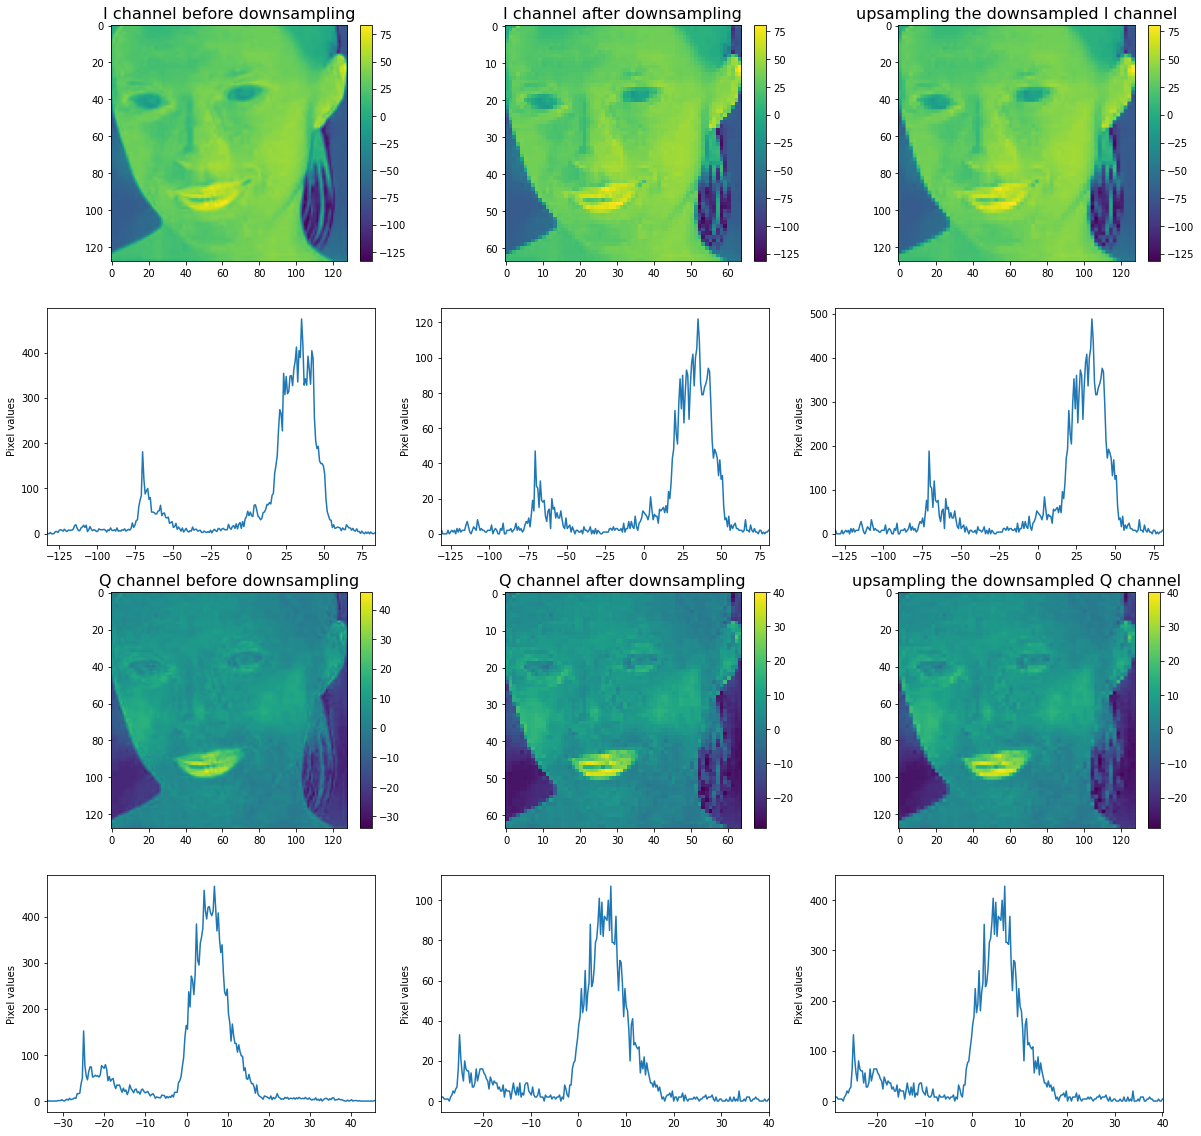

In [9]:
#https://stackoverflow.com/questions/34231244/downsampling-a-2d-numpy-array-in-python/34232507
#https://stackoverflow.com/questions/32846846/quick-way-to-upsample-numpy-array-by-nearest-neighbor-tiling
#https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.colorbar.html

plt.rcParams["figure.figsize"] = [20,20] 
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)    

plt.subplot(4,3,1), plt.imshow(I_channel), plt.title("I channel before downsampling", fontsize = 16), plt.colorbar(fraction=0.046, pad=0.04), plot_histogram(I_channel,4,3,4)
plt.subplot(4,3,7), plt.imshow(Q_channel), plt.title("Q channel before downsampling", fontsize = 16), plt.colorbar(fraction=0.046, pad=0.04), plot_histogram(Q_channel,4,3,10)

def downsample(inputdata, sampling_freq):
         downsampled_img = inputdata[::sampling_freq, ::sampling_freq]   #Downsamples according to the sampling frequency
         return downsampled_img

def upsample(inputdata,sampling_freq):
         upsampled_img = inputdata.repeat(sampling_freq, axis=0).repeat(sampling_freq, axis=1)    #Upsamples according to the sampling frequency
         return upsampled_img

# Downsampling the I-channel
Idown=downsample(I_channel, 2)
plt.subplot(4,3,2), plt.imshow(Idown), plt.title("I channel after downsampling", fontsize = 16), plt.colorbar(fraction=0.046, pad=0.04), plot_histogram(Idown,4,3,5)

# Downsampling the Q-channel
Qdown=downsample(Q_channel,2)
plt.subplot(4,3,8), plt.imshow(Qdown), plt.title("Q channel after downsampling", fontsize = 16), plt.colorbar(fraction=0.046, pad=0.04), plot_histogram(Qdown,4,3,11)

# upsampling the downsampled I-channel
Iup=upsample(Idown,2)
plt.subplot(4,3,3), plt.imshow(Iup), plt.title("upsampling the downsampled I channel", fontsize = 16), plt.colorbar(fraction=0.046, pad=0.04), plot_histogram(Iup,4,3,6)

# upsampling the downsampled Q-channel
Qup=upsample(Qdown,2)
plt.subplot(4,3,9), plt.imshow(Qup), plt.title("upsampling the downsampled Q channel", fontsize = 16), plt.colorbar(fraction=0.046, pad=0.04), plot_histogram(Qup,4,3,12)
plt.show()

In [10]:
#iii) An image is first subdivided in 8x8 subblocks (assuming the original image has sides whose length is a multiple of 8, if it is not the case just resize it).

In [11]:
def subdivision(getimage):                                               #  A function that takes the data in
    (x,y) = getimage.shape[0], getimage.shape[1]       #  Gets the size of the rows and columns which will make it its height and width
    store_blocks = [ ]                                                             #  Stores the 8 x 8 blocks
    for i in range (0,x,8):                                                      #  Step along x = 8
        for j in range (0,y,8):                                                  #  Step along y = 8
            store_blocks.append(getimage[i:i+8,j:j+8]) #  8 x 8 blocks formation
    return store_blocks                                                       # Returns the blocks that's been stored

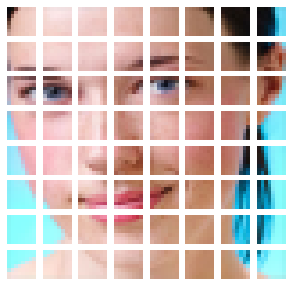

In [12]:
plt.rcParams["figure.figsize"] = [5,5] 

im = resize(im,(64,64,3))                                              # Resizing into a multiple of 8
image_subdivision = subdivision(im)                       # Calling  the function
for x in range(0, len(image_subdivision)):              
    plt.subplot(8, 8, x+1)
    plt.imshow(image_subdivision[x])
    plt.axis("off")
plt.show()

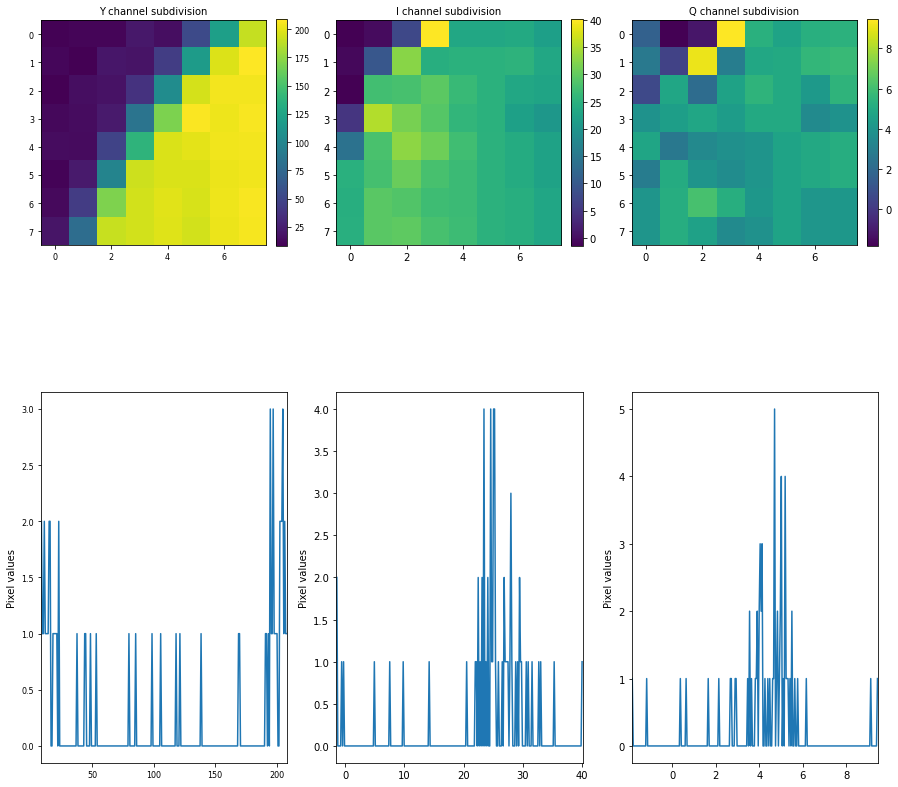

In [13]:
plt.rcParams["figure.figsize"] = [15,15] 
plt.rc('xtick', labelsize=8)
plt.rc('ytick', labelsize=8)    

Y_subdivision= subdivision(Y_channel) # Calling the Y-channel to make 8 x 8 blocks out of it
I_subdivision = subdivision(Idown)        # Calling the downsampled I-channel to make 8 x 8 blocks out of it
Q_subdivision = subdivision(Qdown)    #  Calling the downsampled Q-channel to make 8 x 8 blocks out of it

plt.subplot(2,3,1),plt.imshow(Y_subdivision[0]),plt.title("Y channel subdivision", fontsize = 10), plt.colorbar(fraction=0.046, pad=0.04), plot_histogram(Y_subdivision[0],2,3,4)
plt.subplot(2,3,2),plt.imshow(I_subdivision[0]),plt.title("I channel subdivision", fontsize = 10), plt.colorbar(fraction=0.046, pad=0.04), plot_histogram(I_subdivision[0],2,3,5)
plt.subplot(2,3,3),plt.imshow(Q_subdivision[0]),plt.title("Q channel subdivision", fontsize = 10), plt.colorbar(fraction=0.046, pad=0.04), plot_histogram(Q_subdivision[0],2,3,6)
plt.show()

#print("*** Y_subdivision[0] ***\n\n", Y_subdivision[0])
#print("\n\n*** I_subdivision[0] ***\n\n", I_subdivision[0])
#print("\n\n*** Q_subdivision[0] ***\n\n", Q_subdivision[0])

In [14]:
#iv) A frequency transformation is computed for each block (computed with a discrete cosine transform DCT II )

In [15]:
def dct_2d(im):
    return fftpack.dct(fftpack.dct(im.T, norm='ortho').T, norm='ortho')

def idct_2d(im):
    return fftpack.idct(fftpack.idct(im.T, norm='ortho').T, norm='ortho')

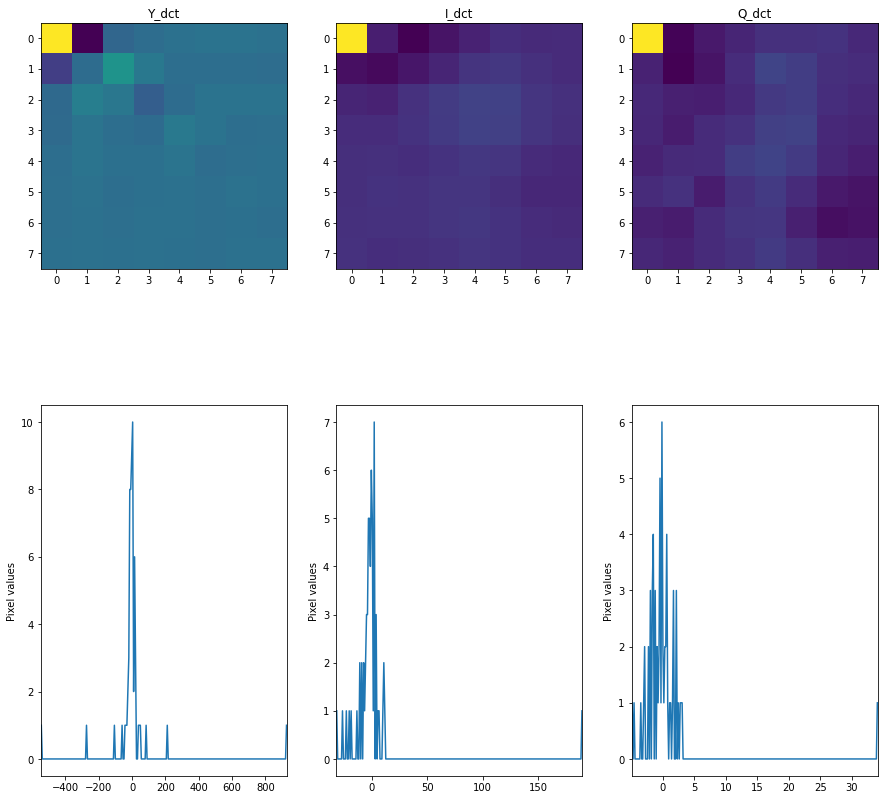

In [16]:
plt.rcParams["figure.figsize"] = [15,15] 
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)    

def getdct(getsubdivisions):
    storedct = [ ]                                                                        # Initializing an empty storage
    for i in range(0, len(getsubdivisions)):                      # step = 1
        storedct.append(dct_2d((getsubdivisions[i]))) # Apply dct _2d for each block 
    return storedct                                                                 # Returns the stored dct values

Y_dct=getdct(Y_subdivision)
plt.subplot(2,3,1),plt.imshow(Y_dct[0]),plt.title("Y_dct"), plot_histogram(Y_dct[0],2,3,4)
    
I_dct=getdct(I_subdivision)
plt.subplot(2,3,2),plt.imshow(I_dct[0]),plt.title("I_dct"), plot_histogram(I_dct[0],2,3,5)

Q_dct=getdct(Q_subdivision)
plt.subplot(2,3,3),plt.imshow(Q_dct[0]),plt.title("Q_dct") ,plot_histogram(Q_dct[0],2,3,6)

plt.show()

#print("*** Y_dct[0] ***\n\n", Y_dct[0])
#print("\n\n*** I_dct[0] ***\n\n", I_dct[0])
#print("\n\n*** Q_dct[0] ***\n\n", Q_dct[0])

In [17]:
# V) The DCT results are then divided by the elements of the the quantization matrices given in quantization_table. 
# The resulting values are then rounded and stored as integers. 

In [18]:
def quantization_table(component='lum'):
    # Quantization Table for: Photoshop 
    # (http://www.impulseadventure.com/photo/jpeg-quantization.html)
    if component == 'lum':
        q = np.array([[2, 2, 2, 2, 3, 4, 5, 6],
                      [2, 2, 2, 2, 3, 4, 5, 6],
                      [2, 2, 2, 2, 4, 5, 7, 9],
                      [2, 2, 2, 4, 5, 7, 9, 12],
                      [3, 3, 4, 5, 8, 10, 12, 12],
                      [4, 4, 5, 7, 10, 12, 12, 12],
                      [5, 5, 7, 9, 12, 12, 12, 12],
                      [6, 6, 9, 12, 12, 12, 12, 12]])
    elif component == "chrom":
        q = np.array([[3, 3, 5, 9, 13, 15, 15, 15],
                      [3, 4, 6, 11, 14, 12, 12, 12],
                      [5, 6, 9, 14, 12, 12, 12, 12],
                      [9, 11, 14, 12, 12, 12, 12, 12],
                      [13, 14, 12, 12, 12, 12, 12, 12],
                      [15, 12, 12, 12, 12, 12, 12, 12],
                      [15, 12, 12, 12, 12, 12, 12, 12],
                      [15, 12, 12, 12, 12, 12, 12, 12]])
    else:
        raise ValueError((
            "component should be either 'lum' or 'chrom', "
            "but '{comp}' was found").format(comp=component))
    return q

In [19]:
#ATTENTION The quatization table assumes the original image intensities before the dct are between 0 and 255

def Quantize(getdct, cst = " " ): # A function that takes dct as a data, divides each element by the quantization table, rounds them off and finally stores it. 
    if (cst =="lum" or cst =="chrom"):
        component=cst
    else:
        print('***Please enter "lum" or "chrom"***')
        
    quantized = [ ]
    for i in range (0,len(getdct)):                                                    #Step = 1
        ratio =( (getdct[i]/quantization_table(component))) #Dividing each element of the dct by  the quantization table
        quantized.append(ratio.astype(np.int32))                      #rounding them off  
    return quantized

quantizedY = Quantize(Y_dct, "lum")
quantizedI = Quantize(I_dct, "chrom")
quantizedQ = Quantize(Q_dct, "chrom")

print("*** Quantized block of  Y ***\n\n", quantizedY[0])
print("\n\n *** Quantized block of  I ***\n\n", quantizedI[0])  
print("\n\n *** Quantized block of  Q ***\n\n", quantizedQ[0])  

*** Quantized block of  Y ***

 [[ 464 -273  -29   -9    2    4    2    0]
 [-136  -13  104   21   -3   -3   -2   -2]
 [ -20   42   20  -52   -6    2    1    1]
 [ -18   11   -7   -7    9    2   -1    0]
 [  -4    7    0    0    2   -2    0    0]
 [  -1    2   -2    0    0    0    0    0]
 [  -1    1    0    0    0    0    0   -1]
 [   0    0    0    0    0    0    0    0]]


 *** Quantized block of  I ***

 [[63 -4 -6 -2  0  0  0  0]
 [-7 -6 -3  0  0  0  0  0]
 [-1 -1  0  0  1  0  0  0]
 [ 0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0]]


 *** Quantized block of  Q ***

 [[11 -1  0  0  0  0  0  0]
 [ 0 -1  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0]]


In [20]:
def Dequantize(getquantized, cst = " " ):# It takes the quantized-data,  multiplies each element by the quantization -table, rounds them off and finally stores and returns it. 
    if (cst =="lum" or cst =="chrom"):
        component=cst
    else:
        print('***Please enter "lum" or "chrom"***')
        
    dequantized = [ ]
    for i in range (0,len(getquantized)):                                                    #Step = 1
        ratio =( (getquantized[i]*quantization_table(component))) # Dividing each element of the dct by  the quantization table
        dequantized.append(ratio.astype(np.int32))                              # Rounding them off  
    return dequantized

dequantizedY = Dequantize(quantizedY , "lum")
dequantizedI = Dequantize(quantizedI, "chrom")
dequantizedQ = Dequantize(quantizedQ, "chrom")


print("***   Dequantized block of  Y   ***\n", dequantizedY[0])
print("\n***   Dequantized block of I   ***\n", dequantizedI[0])  
print("\n***   Dequantized block of Q   ***\n", dequantizedQ[0])  

***   Dequantized block of  Y   ***
 [[ 928 -546  -58  -18    6   16   10    0]
 [-272  -26  208   42   -9  -12  -10  -12]
 [ -40   84   40 -104  -24   10    7    9]
 [ -36   22  -14  -28   45   14   -9    0]
 [ -12   21    0    0   16  -20    0    0]
 [  -4    8  -10    0    0    0    0    0]
 [  -5    5    0    0    0    0    0  -12]
 [   0    0    0    0    0    0    0    0]]

***   Dequantized block of I   ***
 [[189 -12 -30 -18   0   0   0   0]
 [-21 -24 -18   0   0   0   0   0]
 [ -5  -6   0   0  12   0   0   0]
 [  0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0]]

***   Dequantized block of Q   ***
 [[33 -3  0  0  0  0  0  0]
 [ 0 -4  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0]]


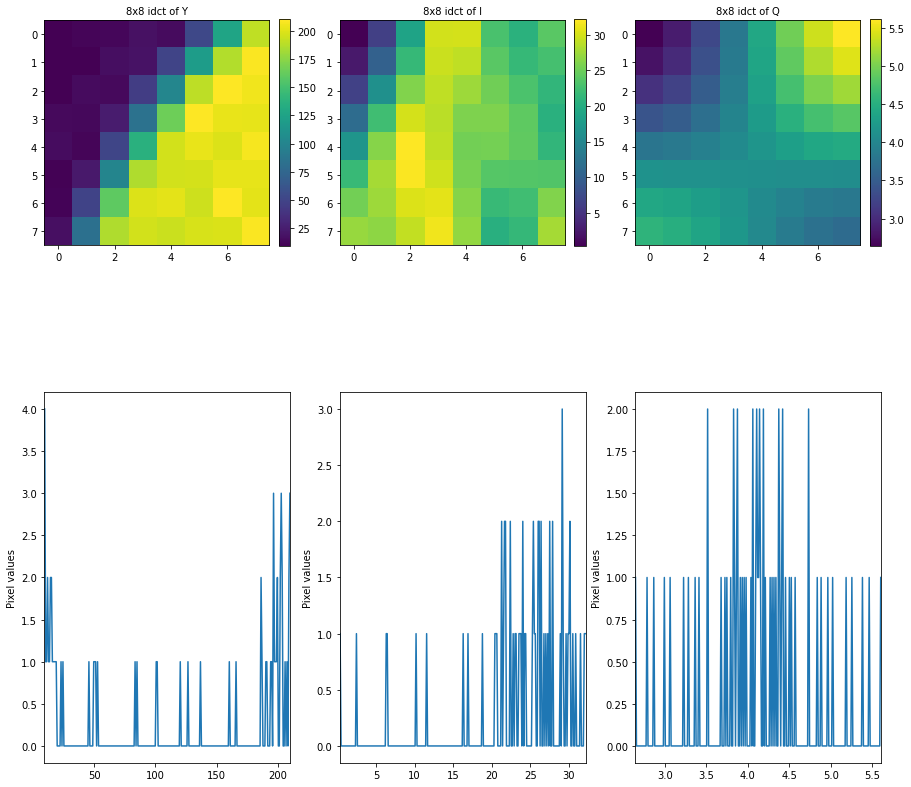

In [21]:
plt.rcParams["figure.figsize"] = [15,15]
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)    

def getidct(getdequantized):                                           #  A function that takes dequantized-values in and applies idct_2d to each block of the data
    storeidct = [ ]                                                                   #  Initilization of empty storage
    for i in range (0,len(getdequantized)):                   #  Step = 1
        storeidct.append(idct_2d(getdequantized[i]))# idct_2d : to each block
    return storeidct

idctY = getidct(dequantizedY)
idctI = getidct(dequantizedI)
idctQ = getidct(dequantizedQ)

plt.subplot(2,3,1), plt.imshow(idctY[0]), plt.title("8x8 idct of Y", fontsize = 10), plt.colorbar(fraction=0.046, pad=0.04), plot_histogram(idctY[0],2,3,4)
plt.subplot(2,3,2), plt.imshow(idctI[0]), plt.title(" 8x8 idct of I ", fontsize = 10), plt.colorbar(fraction=0.046, pad=0.04), plot_histogram(idctI[0],2,3,5)
plt.subplot(2,3,3), plt.imshow(idctQ[0]), plt.title("8x8 idct of Q", fontsize = 10), plt.colorbar(fraction=0.046, pad=0.04), plot_histogram(idctQ[0],2,3,6)
plt.show()

In [22]:
#vii) The reconstruction of the image implies inverting the encoding, the quantization and the dct.
#Implement the inverse steps, to go from the quantized dct values to the reconstructed images

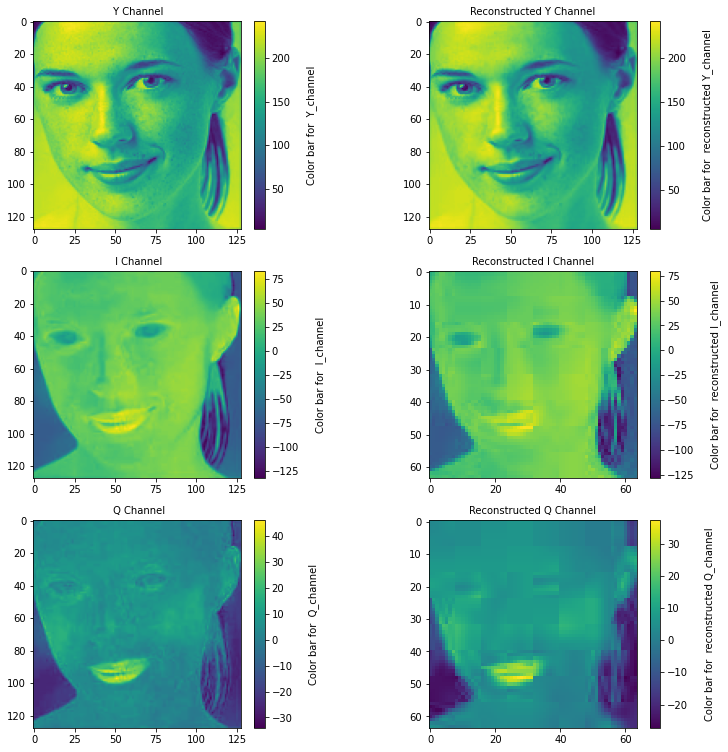

In [23]:
plt.rcParams["figure.figsize"] = [13,13]
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10) 

def  form(getidct, w):                                                             # Reconstruction of an image-function's been initialized
    container = [ ]
    for i in range (0,len(getidct),round(w/8)):
        storeX = np.hstack(getidct[i:i+round(w/8)])
        container.append(storeX)                                            # Stacks each block horizontally and stores them into the container
    storeY = np.vstack(container)                                       # Stacks each row vertically to reconstruct the image
    return storeY                                                                       # Returns the reconstructed image


Y2 = form(idctY ,len(idctY)/2)
I2 = form(idctI ,len(idctI))
Q2 = form(idctQ, len(idctQ))

# Would you like to see the histogram plot for each channel? please make changes in the number of rows and orders  of the channels 
# Before: 3 rows and 2 columns, After:  6 rows and 2 columns
plt.subplot(3,2,1), plt.imshow(Y_channel), plt.colorbar(label="\nColor bar for  Y_channel",fraction=0.046, pad=0.04), plt.title(" Y Channel", fontsize = 10)#,plot_histogram(Y_channel, 6,2,3)
plt.subplot(3,2,3), plt.imshow(I_channel), plt.colorbar(label="\nColor bar for  I_channel",fraction=0.046, pad=0.04), plt.title(" I Channel", fontsize = 10)#, plot_histogram(I_channel, 6,2,7)
plt.subplot(3,2,5), plt.imshow(Q_channel), plt.colorbar(label="\nColor bar for  Q_channel",fraction=0.046, pad=0.04), plt.title(" Q Channel", fontsize = 10)#, plot_histogram(Q_channel, 6,2,11)

plt.subplot(3,2,2), plt.imshow(Y2),plt.colorbar(label="\nColor bar for  reconstructed Y_channel",fraction=0.046, pad=0.04), plt.title("Reconstructed Y Channel", fontsize = 10)#, plot_histogram(Y2, 6,2,4)
plt.subplot(3,2,4), plt.imshow(I2),plt.colorbar(label="\nColor bar for  reconstructed I_channel",fraction=0.046, pad=0.04), plt.title("Reconstructed I Channel", fontsize = 10)#, plot_histogram(I2, 6,2,8) 
plt.subplot(3,2,6), plt.imshow(Q2),plt.colorbar(label="\nColor bar for  reconstructed Q_channel",fraction=0.046, pad=0.04), plt.title("Reconstructed Q Channel", fontsize = 10)#, plot_histogram(Q2, 6,2,12)

plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


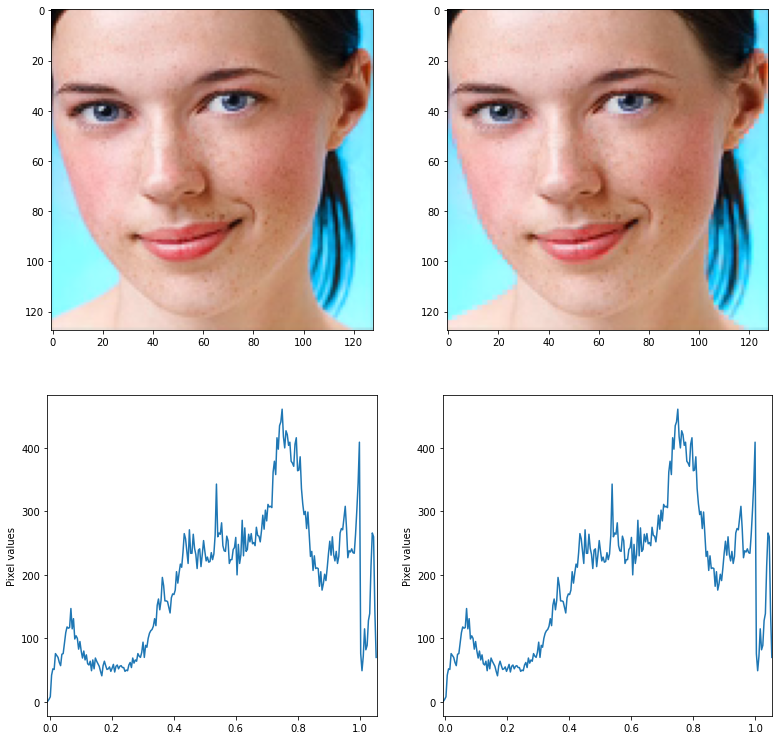

In [24]:
plt.rcParams["figure.figsize"] = [13,13]
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10) 

RGB_reconstruction = YIQ_RGB(Y_channel, Iup, Qup) # Calling the function YIQ_RGB to reconstruct  an RGB- image 
plt.subplot(2,2,1), plt.imshow(RGB_image), plot_histogram(RGB_image, 2,2,3)
plt.subplot(2,2,2), plt.imshow(RGB_reconstruction), plot_histogram(RGB_image, 2,2,4)
plt.show()

In [25]:
# Create a global jpegCompress function englobing steps i-v and a jpegDecompress function englobin steps in vii)

In [26]:
def  JPEGCompression(getimage):

    #print("Original shape: ", getimage.shape)
    
    if( getimage.shape[0] % 16 != 0 or getimage.shape[1] % 16!= 0 ):
        getimage = resize(getimage,(getimage.shape[0]+(16-getimage.shape[0]%16), getimage.shape[1]+(16- getimage.shape[1]%16)))
    
    imageshape = getimage.shape
    #print("Resized shape: ", getimage.shape)
    
    # Step 1 : Changing the color space to YIQ
    YIQimage = RGB_YIQ(getimage)
    
    #Step 2: Down-sampling
    Idown = downsample(YIQimage[:,:,1], 2)
    Qdown = downsample(YIQimage[:,:,2], 2)
    
    #print("Shape of I after down-sampled: ", Idown.shape)
    #print("Shape of Q after down-sampled: ", Qdown.shape)
    
    # Step 3: 8 x 8 blocks formation
    Y_subdivision = subdivision(YIQimage[:,:,0])
    I_subdivision = subdivision(Idown)
    Q_subdivision = subdivision(Qdown)

    # Step 4: Apply dct to each block
    
    Y_dct = getdct(Y_subdivision)
    I_dct = getdct(I_subdivision)
    Q_dct = getdct(Q_subdivision)

    # Step 5: Divide by the quantization table accordingly
    quantizedY = Quantize(Y_dct, "lum")
    quantizedI = Quantize(I_dct, "chrom")
    quantizedQ = Quantize(Q_dct, "chrom")
    
    # Step 6 :I returned these quantized channels, because this'll be the first step  of the decompression
    return quantizedY, quantizedI, quantizedQ, imageshape 

In [27]:
def JPEGDecompression(quantizedY, quantizedI, quantizedQ, imageshape):
    
    #print("Shape: ",imageshape)
    (h,w,c)= imageshape
    
    #Step 5:  Get the quantized values and multiply by the quantization table accordingly
    dequantizedY = Dequantize(quantizedY, "lum")
    dequantizedI = Dequantize(quantizedI, "chrom")
    dequantizedQ = Dequantize(quantizedQ, "chrom")
    
    #Step 4:  Apply IDCT to each block
    idctY = getidct(dequantizedY)
    idctI= getidct(dequantizedI)
    idctQ = getidct(dequantizedQ)
    
    #Step 3:  Form subdivisions
    Y_subdivision = form(idctY,w)
    I_subdivision= form(idctI,w/2)
    Q_subdivision = form(idctQ, w/2)
    
    #Step 2:  Up-sample I and Q  subdivided channels
    Iup = upsample(I_subdivision,2)
    Qup = upsample(Q_subdivision, 2)
    
    #Step 1:  Conversion to an RGB image 
    RGBimage= YIQ_RGB(Y_subdivision, Iup, Qup)
    
    #Boom ! you have successfully formed an RGB -image
    return  RGBimage

In [28]:
filename = "images/Frequency/face2.jpg" # Let's test the function
image = io.imread(filename)
image = (image/255).astype(float) #To be sure is always between 0 and 1 after this cell

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


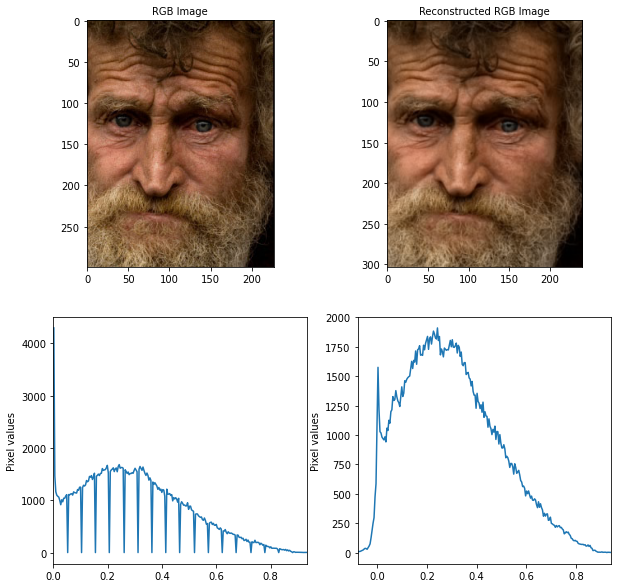

In [29]:
plt.rcParams['figure.figsize'] = [10,10]
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10) 

ycomp, icomp, qcomp, imageshape = JPEGCompression(image)
newimage = JPEGDecompression(ycomp, icomp, qcomp,imageshape)

h = 128
w = 128
resizedimage= resize(image,(h,w),mode='constant')

###################################################
#print("\n*** After Resizing it  ***\n")
###################################################

Ycomp,Icomp,Qcomp, ImageShape = JPEGCompression(resizedimage)
newimageresized = JPEGDecompression(Ycomp,Icomp,Qcomp,ImageShape)

plt.subplot(2,2,1), plt.imshow(image), plt.title("RGB Image", fontsize = 10), plot_histogram(image,2,2,3)
plt.subplot(2,2,2), plt.imshow(newimage), plt.title("Reconstructed RGB Image", fontsize = 10), plot_histogram(newimage,2,2,4)
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


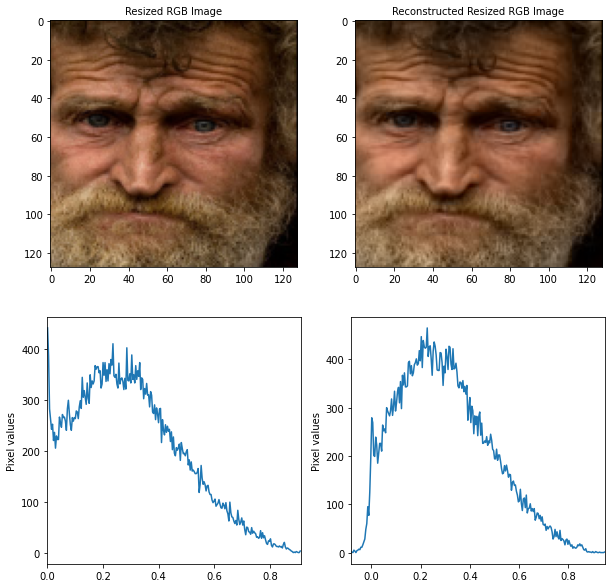

In [30]:
plt.rcParams['figure.figsize'] = [10,10]
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10) 

plt.subplot(2,2,1), plt.imshow(resizedimage), plt.title("Resized RGB Image", fontsize = 10), plot_histogram(resizedimage,2,2,3)
plt.subplot(2,2,2), plt.imshow(newimageresized), plt.title("Reconstructed Resized RGB Image", fontsize = 10), plot_histogram(newimageresized,2,2,4)
plt.show()

In [31]:
#Compare the images (e.g. by computing their differences)

In [32]:
print("*****************************************")
print("Image shape :",image.shape)
print("New image shape :", newimage.shape)
newimage = resize(newimage,(image.shape[0], image.shape[1]),mode='constant') # Making the shape compatible to each other, otherwise operations aren't possible
print("New resized image shape :",newimage.shape)

D1= image-newimage                                # original - reconstructed
D2 = resizedimage-newimageresized  # original resized - reconstructed resized

print("*****************************************")
print("D1 Min = ", D1.min(), "\nD1 Max = ", D1.max())
print("*****************************************")
print("D2 Min = ", np.amin(D2), "\nD2 Max = ", np.amax(D2))
print("*****************************************\n\n")

#print(D1)
#print(D2)

*****************************************
Image shape : (300, 227, 3)
New image shape : (304, 240, 3)
New resized image shape : (300, 227, 3)
*****************************************
D1 Min =  -0.19090084616034697 
D1 Max =  0.1620371683439018
*****************************************
D2 Min =  -0.08895161276249738 
D2 Max =  0.09478106198045255
*****************************************




In [33]:
filename = "images/jpeg/pink.jpg"
image = io.imread(filename)
image = (image/255).astype(float) #  (0/255, 255/255) =  (0, 1)

In [34]:
from scipy.ndimage import gaussian_filter

plt.rcParams['figure.figsize'] = [10,10]
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10) 

gaussian_image = gaussian_filter(image, sigma=1) # Applying gaussian filter 

y, i, q, shape = JPEGCompression(image)
Reconstructed = JPEGDecompression(y, i, q, shape)
Y, I, Q, Shape = JPEGCompression(gaussian_image)
Reconstructed_filtered = JPEGDecompression(Y, I, Q, Shape)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


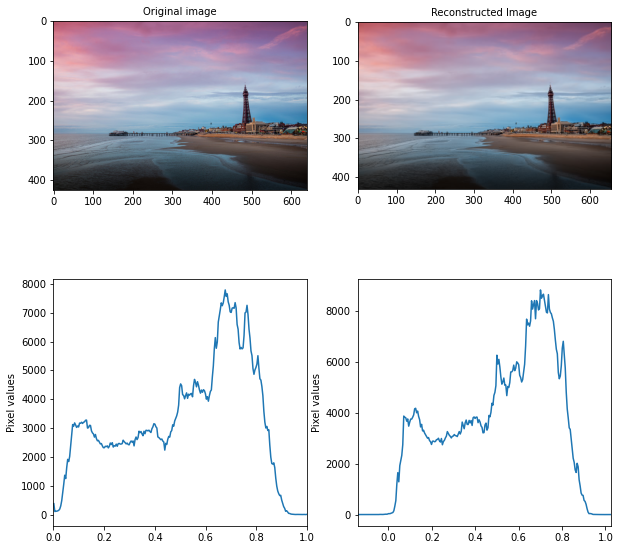

In [35]:
plt.rcParams['figure.figsize'] = [10,10]
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10) 

plt.subplot(2,2,1), plt.imshow(image), plt.title("Original image", fontsize = 10), plot_histogram(image,2,2,3)
plt.subplot(2,2,2), plt.imshow(Reconstructed), plt.title("Reconstructed Image", fontsize = 10), plot_histogram(Reconstructed,2,2,4)
plt.show()

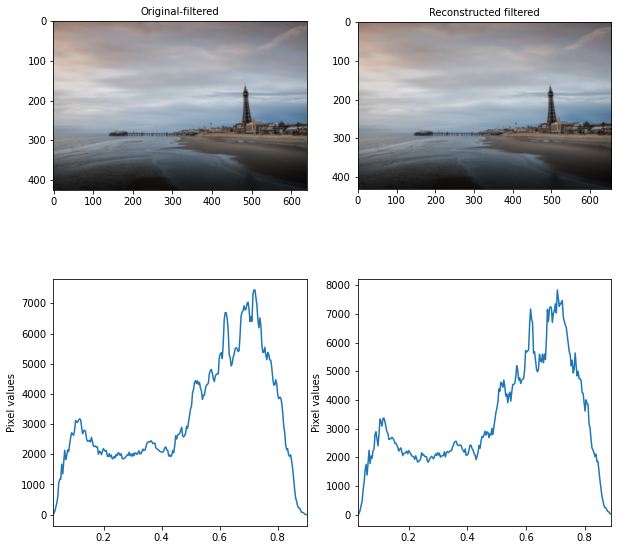

In [36]:
plt.rcParams['figure.figsize'] = [10,10]
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

plt.subplot(2,2,1), plt.imshow(gaussian_image), plt.title("Original-filtered", fontsize = 10), plot_histogram(gaussian_image,2,2,3)
plt.subplot(2,2,2), plt.imshow(Reconstructed_filtered), plt.title("Reconstructed filtered", fontsize = 10), plot_histogram(Reconstructed_filtered,2,2,4)
plt.show()

In [37]:
#Comparing the images (e.g. by computing their differences)

In [38]:
Reconstructed= resize(Reconstructed,(image.shape[0], image.shape[1]),mode='constant')
Reconstructed_filtered = resize(Reconstructed_filtered,(gaussian_image.shape[0], gaussian_image.shape[1]),mode='constant')

D3 = image - Reconstructed                                    # original - reconstructed
D4 = gaussian_image-Reconstructed_filtered    #original filtered - reconstructed filtered

print("*****************************************")
print("D3 Min = ", np.amin(D3), "\nD3 Max = ", np.amax(D3))
print("*****************************************")
print("D4 Min = ", np.amin(D4), "\nD4 Max = ", np.amax(D4))
print("*****************************************\n\n")

#print(D3, "\n\n")
#print(D4)

*****************************************
D3 Min =  -0.4937185504804449 
D3 Max =  0.5192696462058043
*****************************************
D4 Min =  -0.11216184838377319 
D4 Max =  0.09557066290480992
*****************************************




In [39]:
# Call the jpegCompress and jpeg Decompress function on images with high or low frequency content

In [40]:
filename = "images/Frequency/snow.jpg"
low = io.imread(filename)
low = (low/255).astype(float)
low = resize(low,(128,128),mode='constant')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


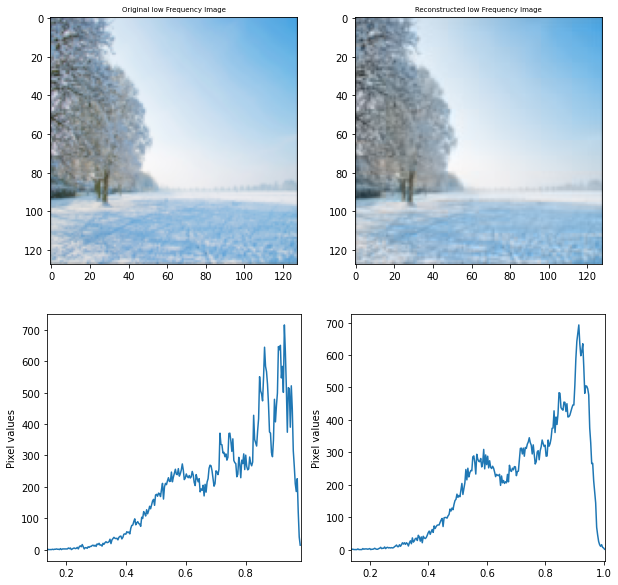

In [41]:
plt.rcParams['figure.figsize'] = [10,10]
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10) 

Y,I,Q,Shape = JPEGCompression(low)
newlow = JPEGDecompression(Y,I,Q,Shape)

plt.subplot(2,2,1), plt.imshow(low), plt.title('Original low Frequency Image', fontsize = 7),plot_histogram(low,2,2,3)
plt.subplot(2,2,2), plt.imshow(newlow), plt.title('Reconstructed low Frequency Image', fontsize = 7),plot_histogram(newlow,2,2,4)
plt.show()

In [42]:
filename = "images/PhaseMag/cat.jpg"
high = io.imread(filename)
high = (high/255).astype(float)
high = resize(high,(128,128),mode='constant')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


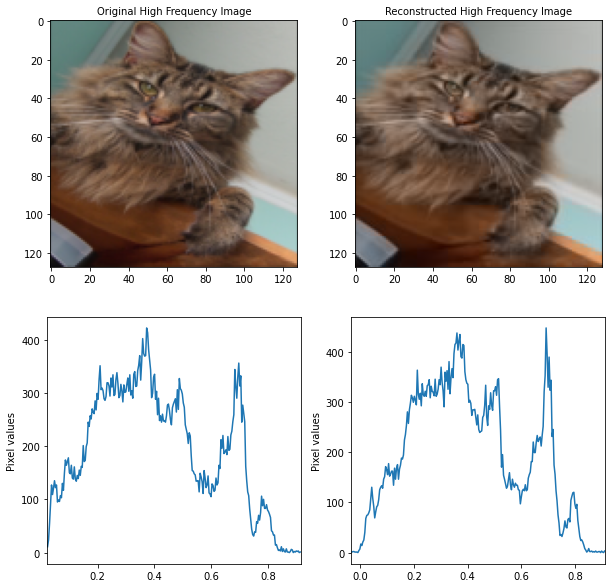

In [43]:
plt.rcParams['figure.figsize'] = [10,10]
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10) 

Y,I,Q,Shape = JPEGCompression(high)
newhigh = JPEGDecompression(Y,I,Q,Shape)

plt.subplot(2,2,1), plt.imshow(high), plt.title("Original High Frequency Image", fontsize = 10),plot_histogram(high,2,2,3)
plt.subplot(2,2,2), plt.imshow(newhigh), plt.title("Reconstructed High Frequency Image", fontsize = 10),plot_histogram(newhigh,2,2,4)
plt.show()

In [44]:
#Comparing the images (e.g. by computing their differences)

*****************************************
D5 Min =  -0.14474111259507763 
D5 Max =  0.1279036751051239
*****************************************
D6 Min =  -0.1456441780751575 
D6 Max =  0.13223922249565778
*****************************************




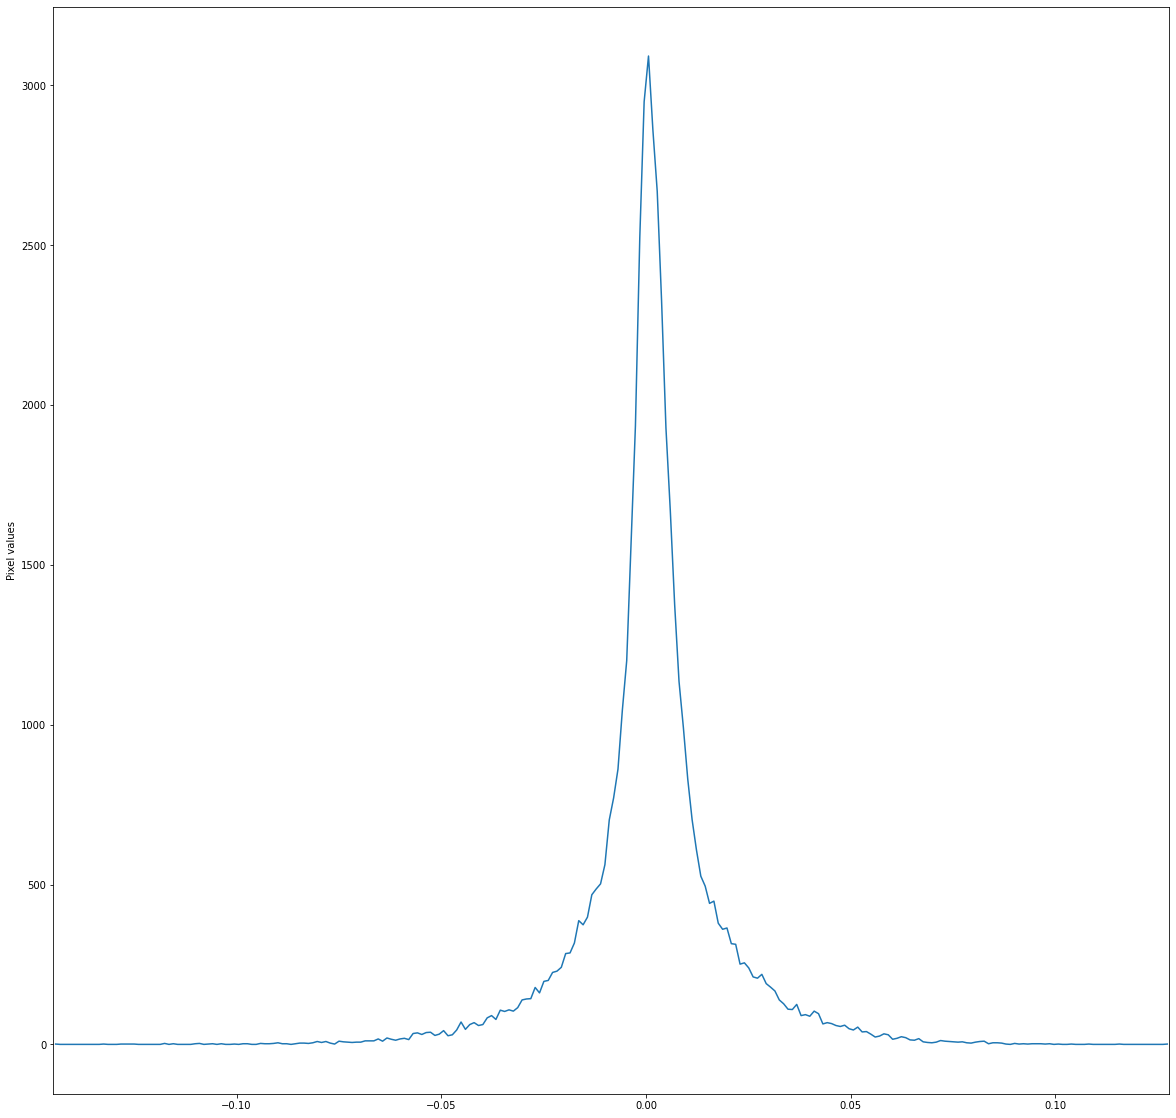

In [46]:
D5 = low-newlow
D6 = high-newhigh

print("*****************************************")
print("D5 Min = ", np.amin(D5), "\nD5 Max = ", np.amax(D5))
print("*****************************************")
print("D6 Min = ", np.amin(D6), "\nD6 Max = ", np.amax(D6))
print("*****************************************\n\n")

#print(D5)
#print(D6)